## Script to create Power Network for US Naval Facility Campus in Annapolis, MD

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import LineString
import contextily as ctx

In [2]:
!pip install openpyxl

## Read the Excel file and create Pandas DataFrame objects

In [3]:
power_pants_df = pd.read_excel('EPN_facilities.xlsx', sheet_name='Power_Plants').set_index('uid')
substations_df = pd.read_excel('EPN_facilities.xlsx', sheet_name='Substations').set_index('uid')

In [4]:
power_pants_df

,Name,Latitude,Longitude,Type
uid,,,,
1,Calvert Cliffs Power Plant,38.431945,-76.441607,Nuclear Power Plant
2,Herbert A Wagner Generating Station,39.177846,-76.525819,Coal and Natural Gas Plant


In [5]:
substations_df

,Name,Latitude,Longitude,Type,From_Node
uid,,,,,
3,BGE Bestgate Substation,38.992267,-76.547425,Transmission,"1, 2"
4,Arnold BGE Substation,39.037100,-76.481000,Distribution,2
5,BGE Greenburry Point Substation,38.996257,-76.473759,Distribution,2
6,BGE US Navy Severn Substation,38.990940,-76.491020,Distribution,3
7,BGE Cedar Park Substation,38.979300,-76.501500,Distribution,3
8,BGE Tyer Avenue Substation,38.960900,-76.491900,Distribution,1


## Create GeoDataFrame objects for demonstration

In [6]:
all_nodes = pd.concat([power_pants_df, substations_df], ignore_index=False)

for rownum, row in all_nodes.iterrows():
    fclttype = row['Type']
    if 'Plant' in fclttype:
        fclttype_new = 'Power Plant'
    elif 'Transmission' in fclttype:
        fclttype_new = 'Transmission Substation'
    else:
        fclttype_new = 'Distribution Substation'
    all_nodes.loc[rownum, 'facility_type'] = fclttype_new

epf_gdf = gpd.GeoDataFrame(all_nodes, 
                       geometry=gpd.points_from_xy(all_nodes['Longitude'], 
                                                   all_nodes['Latitude']),
                       crs="EPSG:4326") 
epf_gdf


,Name,Latitude,Longitude,Type,From_Node,facility_type,geometry
uid,,,,,,,
1,Calvert Cliffs Power Plant,38.431945,-76.441607,Nuclear Power Plant,NaN,Power Plant,POINT (-76.44161 38.43194)
2,Herbert A Wagner Generating Station,39.177846,-76.525819,Coal and Natural Gas Plant,NaN,Power Plant,POINT (-76.52582 39.17785)
3,BGE Bestgate Substation,38.992267,-76.547425,Transmission,"1, 2",Transmission Substation,POINT (-76.54742 38.99227)
4,Arnold BGE Substation,39.037100,-76.481000,Distribution,2,Distribution Substation,POINT (-76.481 39.0371)
5,BGE Greenburry Point Substation,38.996257,-76.473759,Distribution,2,Distribution Substation,POINT (-76.47376 38.99626)
6,BGE US Navy Severn Substation,38.990940,-76.491020,Distribution,3,Distribution Substation,POINT (-76.49102 38.99094)
7,BGE Cedar Park Substation,38.979300,-76.501500,Distribution,3,Distribution Substation,POINT (-76.5015 38.9793)
8,BGE Tyer Avenue Substation,38.960900,-76.491900,Distribution,1,Distribution Substation,POINT (-76.4919 38.9609)


In [7]:
# Interpolate points
def interpolate_coords(start, end, fraction):
    lat1, lon1 = np.radians(start)
    lat2, lon2 = np.radians(end)

    delta = geodesic(start, end).km / 6371  # angular distance in radians
    a = np.sin((1 - fraction) * delta) / np.sin(delta)
    b = np.sin(fraction * delta) / np.sin(delta)

    x = a * np.cos(lat1) * np.cos(lon1) + b * np.cos(lat2) * np.cos(lon2)
    y = a * np.cos(lat1) * np.sin(lon1) + b * np.cos(lat2) * np.sin(lon2)
    z = a * np.sin(lat1) + b * np.sin(lat2)

    lat = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    lon = np.arctan2(y, x)

    return (np.degrees(lat), np.degrees(lon))


In [8]:
num_intervals = 5 # Number of intervals to create in each power line for demonstration
edge_gdf = []

for sub_id, row in substations_df.iterrows():
    fromnodes = row['From_Node']
    if not isinstance(fromnodes, int):
        fromnodes = [int(num) for num in fromnodes.split(',')]
    else:
        fromnodes = [fromnodes]
    
    tonode = sub_id
    
    for fromnode in fromnodes:
        
        facility_type = all_nodes.loc[fromnode, 'Type']
        
        if 'Plant' in facility_type:
            linetype = 'Transmission Line'
        else:
            linetype = 'Distribution Line'
        
        start = [all_nodes.loc[fromnode, 'Latitude'], all_nodes.loc[fromnode, 'Longitude']]
        end = [row['Latitude'], row['Longitude']]
    
        # Total distance in km
        total_distance = geodesic(start, end).km

        # Create evenly spaced fractions (0 to 1)
        fractions = np.linspace(0, 1, num_intervals + 1)
        
        points = [interpolate_coords(start, end, f) for f in fractions]
        
        # Flip (Lat, Lon) to (Lon, Lat) for geometry
        line = LineString([(lon, lat) for lat, lon in points])
        
        edge_gdf.append({'fromnode': fromnode, 'tonode': tonode, 'linetype': linetype, 'geometry': line})
        
# Create GeoDataFrame
epn_gdf = gpd.GeoDataFrame(edge_gdf, crs='EPSG:4326')
epn_gdf

,fromnode,tonode,linetype,geometry
0,1,3,Transmission Line,"LINESTRING (-76.44161 38.43194, -76.46264 38.5..."
1,2,3,Transmission Line,"LINESTRING (-76.52582 39.17785, -76.53015 39.1..."
2,2,4,Transmission Line,"LINESTRING (-76.52582 39.17785, -76.51684 39.1..."
3,2,5,Transmission Line,"LINESTRING (-76.52582 39.17785, -76.51539 39.1..."
4,3,6,Distribution Line,"LINESTRING (-76.54742 38.99227, -76.53614 38.9..."
5,3,7,Distribution Line,"LINESTRING (-76.54742 38.99227, -76.53824 38.9..."
6,1,8,Transmission Line,"LINESTRING (-76.44161 38.43194, -76.45161 38.5..."


## Visualize

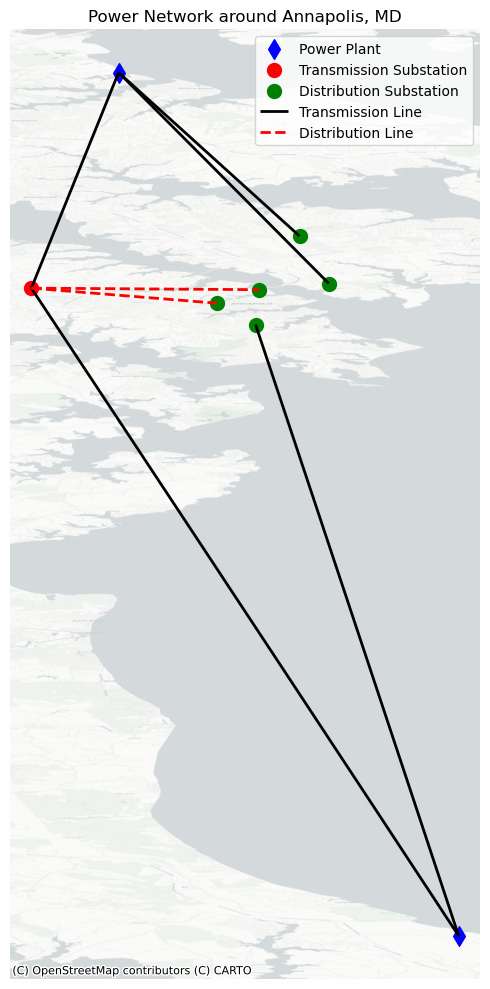

In [9]:
# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(5, 10))

# Convert all GeoDataFrames to Web Mercator (for basemap)
epn_gdf_plot = epn_gdf.to_crs(epsg=3857)
epf_gdf_plot = epf_gdf.to_crs(epsg=3857)

# Plot points with unique markers for each 'Type'
types_points = epf_gdf_plot['facility_type'].unique()
for t in types_points:
    if 'Plant' in t:
        pointlabel = t
        marker = 'd'
        color = 'blue'
    elif 'Transmission' in t:
        pointlabel = t
        marker = 'o'
        color = 'red'
    else:
        pointlabel = t
        marker = 'o'
        color = 'green'
    epf_gdf_plot[epf_gdf_plot['facility_type'] == t].plot(ax=ax, marker=marker, color = color,
                                                             markersize=100, label=f'{pointlabel}')

# Plot lines with unique line styles for each 'Type'
types_lines = epn_gdf_plot['linetype'].unique()
for t in types_lines:
    if 'Transmission' in t:
        color = 'k'
        linestyle = '-'
    else:
        color = 'r'
        linestyle = '--'
    epn_gdf_plot[epn_gdf_plot['linetype'] == t].plot(ax=ax, linestyle=linestyle, color = color,
                                                   linewidth=2, label=f'{t}')

# Customize the legend to avoid overlapping
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Categories")
ax.set_aspect('auto')  # Allow aspect ratio to stretch

# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=14)

plt.legend()
plt.title("Power Network around Annapolis, MD")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("off")
plt.tight_layout()
plt.show()

## Next, read the building datasets

In [10]:
building_data = pd.read_excel('EPN_facilities.xlsx', sheet_name='Buildings').set_index('uid')
building_data

,Building_name,Latitude,Longitude,Base_elevation,Floors,Height,Occupancy,From_Node
uid,,,,,,,,
1,House1,38.980200,-76.485999,0,2,30,RES3,6
2,House2,38.979932,-76.485676,0,2,30,RES3,6
3,House3,38.979717,-76.485350,0,2,30,RES3,6
4,House4,38.979495,-76.485058,0,2,30,RES3,6
5,House5,38.979286,-76.484716,0,2,30,RES3,6
6,House6,38.979127,-76.484436,0,2,30,RES3,6
7,House7,38.979546,-76.484895,0,2,30,RES3,6
8,Main Hall,38.981453,-76.482890,0,3,40,EDU2,6
9,US Naval Academy Museum,38.982788,-76.487257,0,3,40,EDU2,6


In [11]:
building_gdf = gpd.GeoDataFrame(building_data, 
                                geometry=gpd.points_from_xy(building_data['Longitude'], 
                                                            building_data['Latitude']), 
                                crs="EPSG:4326")

In [12]:
building_gdf

,Building_name,Latitude,Longitude,Base_elevation,Floors,Height,Occupancy,From_Node,geometry
uid,,,,,,,,,
1,House1,38.980200,-76.485999,0,2,30,RES3,6,POINT (-76.486 38.9802)
2,House2,38.979932,-76.485676,0,2,30,RES3,6,POINT (-76.48568 38.97993)
3,House3,38.979717,-76.485350,0,2,30,RES3,6,POINT (-76.48535 38.97972)
4,House4,38.979495,-76.485058,0,2,30,RES3,6,POINT (-76.48506 38.9795)
5,House5,38.979286,-76.484716,0,2,30,RES3,6,POINT (-76.48472 38.97929)
6,House6,38.979127,-76.484436,0,2,30,RES3,6,POINT (-76.48444 38.97913)
7,House7,38.979546,-76.484895,0,2,30,RES3,6,POINT (-76.48489 38.97955)
8,Main Hall,38.981453,-76.482890,0,3,40,EDU2,6,POINT (-76.48289 38.98145)
9,US Naval Academy Museum,38.982788,-76.487257,0,3,40,EDU2,6,POINT (-76.48726 38.98279)


## Connect the power network to the buildings

At this point we use the logic that all buildings are connected to the same substation, i.e., the US Navy Severn Substation that is closest to the US Naval Academy Campus. However, this can be updated in future.

In [13]:
edges_bldg_subs_df = []
# i = 0

for rownum, row in building_gdf.iterrows():
    from_sub = row['From_Node']
    if not isinstance(from_sub, int):
        from_sub = [int(num) for num in from_sub.split(',')]
    else:
        from_sub = [from_sub]

    tonode = rownum
    
    for fromnode in from_sub:
        # edges_bldg_subs_df.loc[i, 'inode_substation'] = fromnode
        # edges_bldg_subs_df.loc[i, 'jnode_building'] = tonode

        start = [all_nodes.loc[fromnode, 'Latitude'], all_nodes.loc[fromnode, 'Longitude']]
        end = [row['Latitude'], row['Longitude']]

        points = [(all_nodes.loc[fromnode, 'Latitude'], all_nodes.loc[fromnode, 'Longitude']), 
                 (row['Latitude'], row['Longitude'])]

        line = LineString([(lon, lat) for lat, lon in points])
        
        edges_bldg_subs_df.append({'inode_substation': fromnode, 
                                   'jnode_building': tonode, 
                                   'linetype': linetype, 
                                   'geometry': line})
        
        # i += 1
edges_bldg_subs_df = gpd.GeoDataFrame(edges_bldg_subs_df, crs='EPSG:4326')
edges_bldg_subs_df['inode_substation'] = edges_bldg_subs_df['inode_substation'].astype(int)
edges_bldg_subs_df['jnode_building'] = edges_bldg_subs_df['jnode_building'].astype(int)

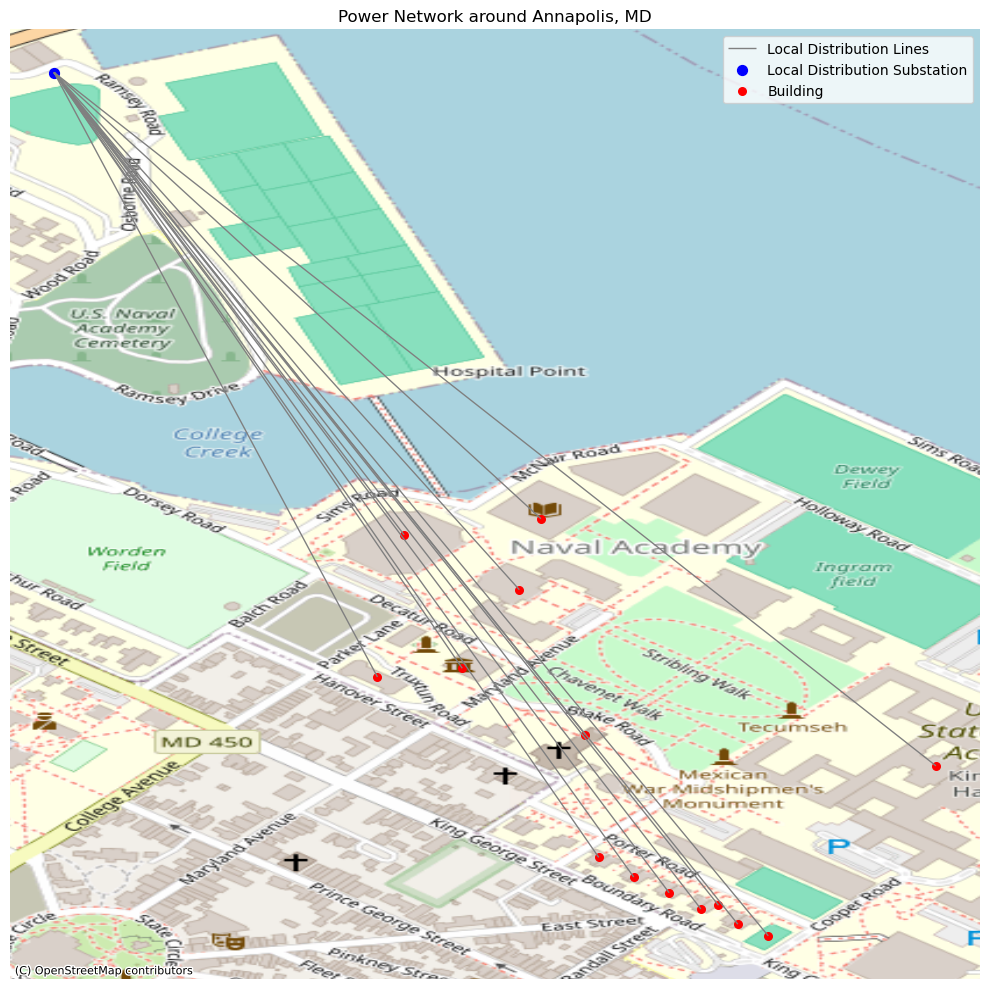

In [14]:
# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Convert all GeoDataFrames to Web Mercator (for basemap)
edges_bldg_subs_df_plot = edges_bldg_subs_df.to_crs(epsg=3857)
building_gdf_plot = building_gdf.to_crs(epsg=3857)
subs_df_plot = epf_gdf_plot.loc[edges_bldg_subs_df['inode_substation'].unique()]

edges_bldg_subs_df_plot.plot(ax=ax, color="gray", linewidth=1, label="Local Distribution Lines")
subs_df_plot.plot(ax=ax, marker = 'o', color="blue", markersize=50, label="Local Distribution Substation")
building_gdf_plot.plot(ax=ax, marker = 'o', color="red", markersize=30, label="Building")

# Customize the legend to avoid overlapping
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Categories")
ax.set_aspect('auto')  # Allow aspect ratio to stretch

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Add basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=14)

plt.legend()
plt.title("Power Network around Annapolis, MD")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("off")
plt.tight_layout()
plt.show()

## Save the generated files

In [15]:
# Save power network as shapefiles
epf_gdf.to_file("input_data/epf_nodes_updated.shp")
epn_gdf.to_file("input_data/epn_links_updated.shp")

# Save the building data as shapefiles
building_gdf.to_file("input_data/sample_buildings.shp")

# Save the local distribution network as a shapefile
edges_bldg_subs_df.to_file("input_data/subs_to_bldgs_edges.shp")

C:\Users\sum223\AppData\Local\Temp\ipykernel_2128\2773560442.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  epf_gdf.to_file("input_data/epf_nodes_updated.shp")
C:\Users\sum223\AppData\Local\anaconda3\envs\pyincoreEnv\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'facility_type' to 'facility_t'
  ogr_write(
C:\Users\sum223\AppData\Local\Temp\ipykernel_2128\2773560442.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  building_gdf.to_file("input_data/sample_buildings.shp")
C:\Users\sum223\AppData\Local\anaconda3\envs\pyincoreEnv\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Building_name' to 'Building_n'
  ogr_write(
C:\Users\sum223\AppData\Local\anaconda3\envs\pyincoreEnv\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Base_elevation' to 'Base_eleva'